# K Means Clustering & EDA

## Abstract


A KMeans Clustering analysis using the transational retail data set, a "data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers."


The KMeans analysis resulted in 3 groups of customers; those who order more frequently and spend more money, a group who make smaller orders very infrequently, and another group in the middle of these two in terms of spending habits. While these groups aren't a ground-breaking classification of customers, it does help to have approximate boundaries for customer behaviour groups, and the results can be fed into a predictive model to aid in forecasting

### Initialisation

In [1]:
# import required libraries for dataframe and visualization

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
sns.set()

# import required libraries for clustering
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [2]:
# Load the data

retail  = pd.read_excel('Online Retail.xlsx', sheet = None)

retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
# shape of df
retail.shape

(541909, 8)

In [4]:
# df info
retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null datetime64[ns]
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [5]:
# df description

retail.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


## Data Cleaning and Preprocessing

In [6]:
#Missing values
df_null = round(100*(retail.isnull().sum())/len(retail), 2)
df_null

InvoiceNo       0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.93
Country         0.00
dtype: float64

In [7]:
# Drop missing values

retail = retail.dropna()
retail.describe()

,Quantity,UnitPrice,CustomerID
count,406829.000000,406829.000000,406829.000000
mean,12.061303,3.460471,15287.690570
std,248.693370,69.315162,1713.600303
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13953.000000
50%,5.000000,1.950000,15152.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [8]:
# Also change customer ID to string

retail['CustomerID'] = retail['CustomerID'].astype(str)

### Initialisation of Analysis Factors

We'll be analysing the the total monetary amount spent by the customers and the frequency of their transactions to gain a better understanding of customer behaviour

In [9]:
#New Attribute: Monetary

retail['Amount'] = retail['Quantity']*retail['UnitPrice']
fm_m = retail.groupby('CustomerID')['Amount'].sum()
fm_m = fm_m.reset_index()
fm_m.head()

,CustomerID,Amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [10]:
# New Attribute : Frequency

fm_f = retail.groupby('CustomerID')['InvoiceNo'].count()
fm_f = fm_f.reset_index()
fm_f.columns = ['CustomerID', 'Frequency']
fm_f.head()

,CustomerID,Frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [11]:
fm = pd.merge(fm_m, fm_f, on='CustomerID', how='inner')
fm.head()

,CustomerID,Amount,Frequency
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


### Check for Outliers

Text(0.5, 0, 'Attributes')

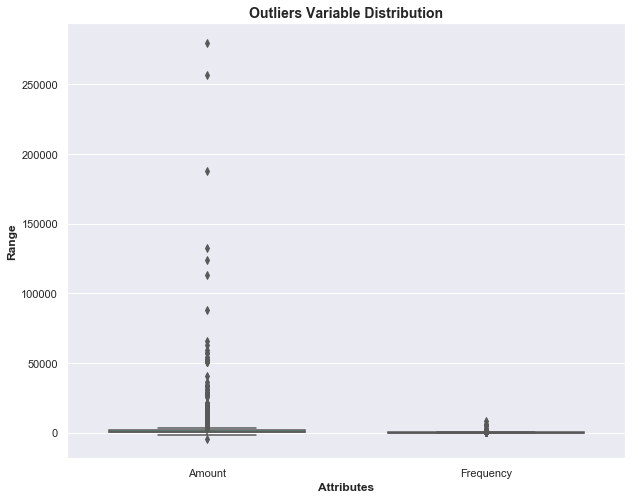

In [12]:
# Outlier Analysis of Amount and Frequency

attributes = ['Amount','Frequency']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = fm[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

In [13]:
# Removing statistical outliers

#for Amount
Q1 = fm.Amount.quantile(0.05)
Q3 = fm.Amount.quantile(0.95)
IQR = Q3 - Q1
fm = fm[(fm.Amount >= Q1 - 1.5*IQR) & (fm.Amount <= Q3 + 1.5*IQR)]



#  for Frequency
Q1 = fm.Frequency.quantile(0.05)
Q3 = fm.Frequency.quantile(0.95)
IQR = Q3 - Q1
fm = fm[(fm.Frequency >= Q1 - 1.5*IQR) & (fm.Frequency <= Q3 + 1.5*IQR)]

### Rescale for analysis

In [14]:
# Rescaling the attributes

fm_df = fm[['Amount', 'Frequency']]

# Instantiate
scaler = StandardScaler()

# fit_transform
fm_df_scaled = scaler.fit_transform(fm_df)
fm_df_scaled.shape

C:\Users\josep\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\josep\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


(4293, 2)

In [15]:
fm_df_scaled = pd.DataFrame(fm_df_scaled)
fm_df_scaled.columns = ['Amount', 'Frequency']
fm_df_scaled.head()

,Amount,Frequency
0,-0.723738,-0.752888
1,1.731617,1.042467
2,0.300128,-0.463636
3,0.277517,-0.044720
4,-0.533235,-0.603275


## Building the Model

<function matplotlib.pyplot.show(*args, **kw)>

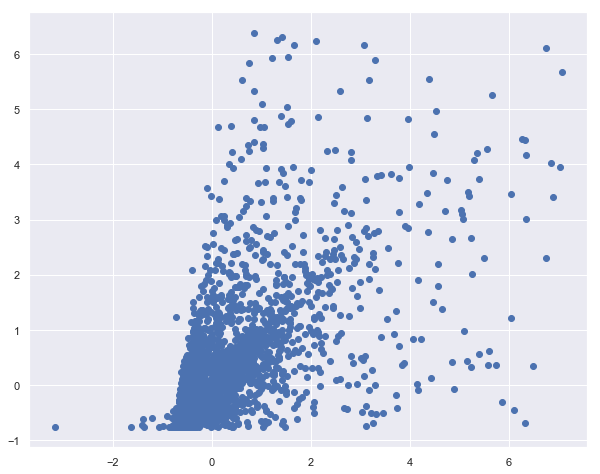

In [16]:
#Scatterplot of data

plt.scatter(fm_df_scaled['Amount'],fm_df_scaled['Frequency'])
plt.show

In [17]:
#Initialise KMeans with random k value

kmeans = KMeans(n_clusters = 5, max_iter = 75)
kmeans.fit(fm_df_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=75,
    n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

### Find Optimal Number of Clusters using Elbow Method

In [18]:
wcss=[]
for i in range (1,7):
    kmeans = KMeans(i)
    kmeans.fit(fm_df_scaled)
    wcss_iter = kmeans.inertia_
    wcss.append(wcss_iter)
    



In [19]:
wcss

[8586.0,
 3699.1681453044775,
 2488.100069529663,
 1911.3622495007098,
 1534.3865118454783,
 1294.533804151819]

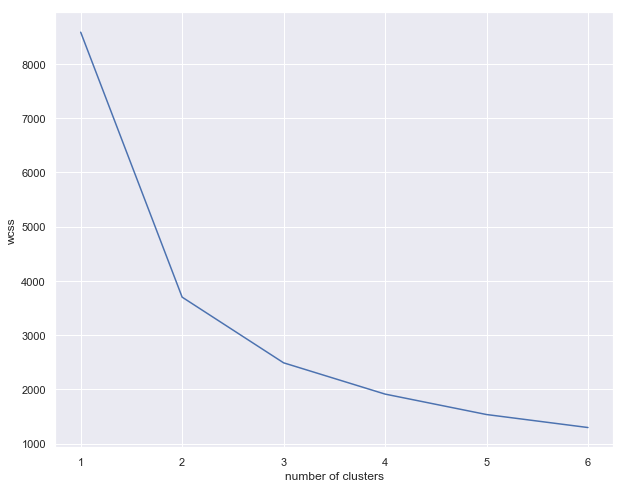

In [20]:
number_clusters = range(1,7)

plt.plot(number_clusters,wcss)
plt.xlabel('number of clusters')
plt.ylabel('wcss')
plt.show()

In [21]:
#continuing with k = 3

kmeans_new = KMeans(n_clusters = 3, max_iter = 75)
kmeans_new.fit(fm_df_scaled)
identified_clusters = kmeans_new.fit_predict(fm_df_scaled)

In [22]:
# Put clusters back into original df
fm['Cluster'] = kmeans_new.labels_
fm.head()

,CustomerID,Amount,Frequency,Cluster
0,12346.0,0.00,2,0
1,12347.0,4310.00,182,2
2,12348.0,1797.24,31,0
3,12349.0,1757.55,73,0
4,12350.0,334.40,17,0


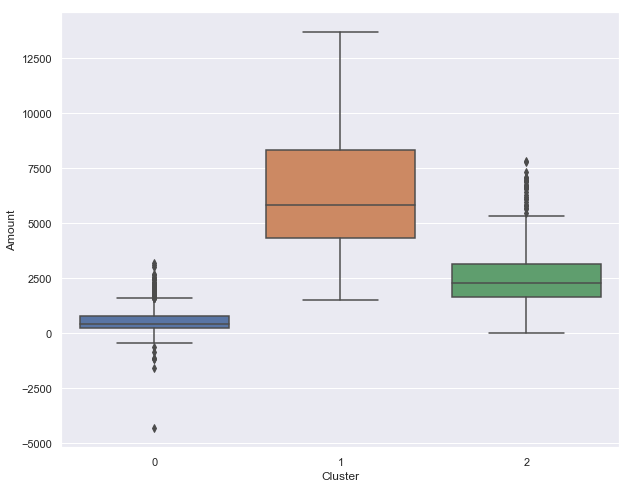

In [24]:
sns.boxplot(fm['Cluster'],fm['Amount'])

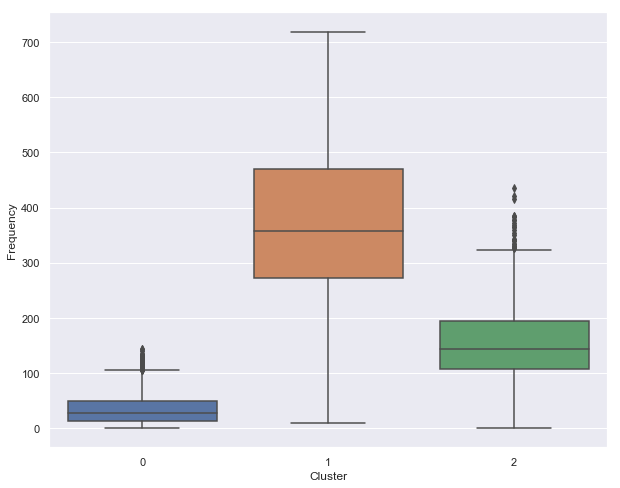

In [26]:
sns.boxplot(fm['Cluster'],fm['Frequency'])